# Objective #1

In [638]:
from itertools import product
import json

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import tree, linear_model
from sklearn.metrics import *
from scipy.stats import pearsonr

import random
np.random.seed(0)
random.seed(0)

In [639]:
df = pd.read_csv("parkinsons_updrs.data")
n, m = df.shape

## 1.1. Dataset preparation
### 1.1.1. Shuffle and Split into training and IVS
- `train_df` -- training set for model training/selection
- `ivs_df` -- independet validation set (IVS) for the final benchmark

In [640]:
df = df.sample(frac=1)
train_size = int(0.8 * n)
train_df = df.iloc[:train_size]
ivs_df = df.iloc[train_size:]

In [641]:
#train_x = np.array(train_df[['Jitter(%)', 'Shimmer', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']])
train_x = np.array(train_df[['age', 'sex', 'Jitter(%)', 'Shimmer', 'HNR', 'RPDE', 'DFA', 'PPE']])
train_y = np.array(train_df["motor_UPDRS"])

#ivs_x = np.array(ivs_df[['Jitter(%)', 'Shimmer', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']])
ivs_x = np.array(ivs_df[['age', 'sex', 'Jitter(%)', 'Shimmer', 'HNR', 'RPDE', 'DFA', 'PPE']])
ivs_y = np.array(ivs_df["motor_UPDRS"])

### 1.1.2. Scale data

In [642]:
x_mean  = np.mean(train_x, axis=0)
x_std   = np.std(train_x, axis=0)
train_x = (train_x - x_mean) / x_std
y_mean  = np.mean(train_y, axis=0)
y_std  = np.std(train_y, axis=0)
train_y = (train_y - y_mean) / y_std
ivs_x_scaled = (ivs_x - np.mean(ivs_x, axis=0)) / np.std(ivs_x, axis=0)

### 1.2.Validation techniques (shared for regression and classification)

In [643]:
def simple_cross_validation(*, model, x, y, train_partition=(0, 0.8), metrics={"mae": mean_absolute_error}):
    n, m = x.shape
    
    start = int(train_partition[0] * n)
    end = int(train_partition[1] * n)
    
    x_train = x[start:end, :]
    y_train = y[start:end]
    x_test = np.concatenate((x[:start, :], x[end:, :]))
    y_test = np.concatenate((y[:start], y[end:]))
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    return {metric_name: metric_f(y_test, y_pred) for (metric_name, metric_f) in metrics.items()}


def kfold(*, model, x, y, k=5, metrics={"mae": mean_absolute_error}):
    n, m = x.shape
    results = {metric: 0 for metric in metrics.keys()}
    
    for i in range(k):
        start = i * (1/k)
        end = start + (1/k)
        if (i + 1) == k:
            end = 1.0
            
        iteration_results = simple_cross_validation(model=model, x=x, y=y, train_partition=(start, end), metrics=metrics)
        
        for metric in metrics.keys():
            results[metric] += iteration_results[metric]
    
    for metric in results.keys():
        results[metric] /= k
    
    return results

### 1.3. Model Selection

In [644]:
def results2df(hyperparams_names, hyperparams_values, results, metrics):
    if len(hyperparams_names) > 1:
        index = pd.MultiIndex.from_tuples(hyperparams_values, names=hyperparams_names)
    else:
        index = pd.Index(hyperparams_values, name=hyperparams_names[0])
    data = [[m for m in v["evaluation"].values()] for v in results.values()]
    results = pd.DataFrame(data, index=index, columns=metrics.keys())
    results = results.style.format({m: '{:.3f}' for m in metrics.keys()}, escape="latex").format_index(escape="latex")
    print(results.to_latex())
    return results


def tree_regressor_selection(x: np.ndarray, y: np.ndarray, metrics, validation):
    # Hyperparameters
    criterions = ["squared_error", "friedman_mse"]
    splitters = ["best"]
    max_depths = [5, 10, 20, 50, None]
    hyper_parameters = list(product(criterions, splitters, max_depths))
    
    results = {}
    
    for p in hyper_parameters:
        criterion, splitter, max_depth = p
        
        model = tree.DecisionTreeRegressor(criterion=criterion,
                                           splitter=splitter,
                                           max_depth=max_depth)
        model_results = validation(model, x, y, metrics)
        model_name = "tree-" + "-".join([str(param) for param in p])
        results[model_name] = {"model": model, "evaluation": model_results}

    results2df(["criterion", "splitter", "max_depth"], hyper_parameters, results, metrics)
        
    return results


def linear_regression_selection(x: np.ndarray, y: np.ndarray, metrics, validation):
    results = {}

    model = linear_model.LinearRegression()
    model_results = validation(model, x, y, metrics)
    results[f"lineareg"] = {"model": model, "evaluation": model_results}
    
    print(f"Linear regression results: {results[f'lineareg']['evaluation']}")

    return results


def ridge_selection(x: np.ndarray, y: np.ndarray, metrics, validation):
    results = {}
    
    alphas = [*[10**p for p in range(-5,2)], *[]]
    for alpha in alphas:
        model = linear_model.Ridge(alpha=alpha)
        model_results = validation(model, x, y, metrics)
        results[f"ridge-{alpha}"] = {"model": model, "evaluation": model_results}
        
    results2df(["alpha"], alphas, results, metrics)
        
    return results

def lasso_selection(x: np.ndarray, y: np.ndarray, metrics, validation):
    results = {}
    
    alphas = [*[10**p for p in range(-5,2)], *[]]
    for alpha in alphas:
        model = linear_model.Lasso(alpha=alpha)
        model_results = validation(model, x, y, metrics)
        results[f"lasso-{alpha}"] = {"model": model, "evaluation": model_results}
        
    results2df(["alpha"], alphas, results, metrics)
    return results

        
def model_selection(x: np.ndarray, y: np.ndarray):
    metrics = {"mae": lambda y_true, y_pred: y_std * mean_absolute_error(y_true, y_pred), "rve": explained_variance_score, "r2": r2_score}
    validation_technique = lambda model, x, y, metrics: kfold(model=model, x=x, y=y, k=10, metrics=metrics)
    
    results = {}
    results |= tree_regressor_selection(x, y, metrics, validation_technique)
    results |= linear_regression_selection(x, y, metrics, validation_technique)
    results |= ridge_selection(x, y, metrics, validation_technique)
    results |= lasso_selection(x, y, metrics, validation_technique)
    
    best_model_name = max(results, key=lambda model: results[model]["evaluation"]["rve"])
    best_model = results[best_model_name] | {"name": best_model_name}
        
    return best_model, results

best_regressor, other_regressors = model_selection(train_x, train_y)
print(f"Best Model: {best_regressor['name']}")
print(f"Best Model Results: {best_regressor['evaluation']}")
# print(json.dumps({"-".join([str(p) for p in k]): v["avg_evaluation"] for (k, v) in results.items()}, indent=4))

\begin{tabular}{lllrrr}
 &  &  & mae & rve & r2 \\
criterion & splitter & max_depth &  &  &  \\
\multirow[c]{5}{*}{squared\_error} & \multirow[c]{5}{*}{best} & 5.000000 & 4.570 & 0.437 & 0.436 \\
 &  & 10.000000 & 3.669 & 0.483 & 0.481 \\
 &  & 20.000000 & 3.716 & 0.458 & 0.456 \\
 &  & 50.000000 & 3.721 & 0.457 & 0.455 \\
 &  & nan & 3.687 & 0.467 & 0.465 \\
\multirow[c]{5}{*}{friedman\_mse} & \multirow[c]{5}{*}{best} & 5.000000 & 4.565 & 0.439 & 0.438 \\
 &  & 10.000000 & 3.682 & 0.483 & 0.481 \\
 &  & 20.000000 & 3.721 & 0.458 & 0.457 \\
 &  & 50.000000 & 3.722 & 0.458 & 0.457 \\
 &  & nan & 3.706 & 0.463 & 0.461 \\
\end{tabular}

Linear regression results: {'mae': 6.46717699377926, 'rve': 0.10947448002201532, 'r2': 0.10833629033940603}
\begin{tabular}{lrrr}
 & mae & rve & r2 \\
alpha &  &  &  \\
0.000010 & 6.467 & 0.109 & 0.108 \\
0.000100 & 6.467 & 0.109 & 0.108 \\
0.001000 & 6.467 & 0.109 & 0.108 \\
0.010000 & 6.467 & 0.109 & 0.108 \\
0.100000 & 6.467 & 0.109 & 0.108 \\
1.000000 

## 1.4. Validate against IVS

--- Regressor ---
Model: tree-friedman_mse-best-10
21.29284085106383
[19.84  22.88  20.827 ... 15.    18.    11.117]
Performance on IVS: {'mae': 3.5193063192464606, 'rve': 0.5551174398743989, 'r2': 0.5500932527203127, 'pearson_corr': (0.7691670707137763, 2.352284756602611e-230)}
MAE: 3.5193063192464606 
RVE: 0.5551174398743989
Pearson Correlation Score: (0.7691670707137763, 2.352284756602611e-230)


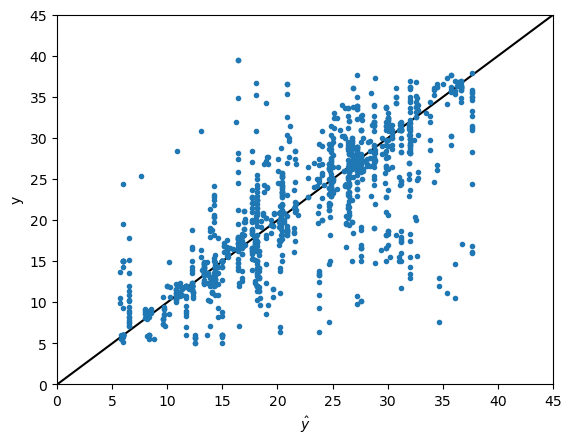

In [645]:
def validate_regressor_agains_ivs(*, model, ivs_x, ivs_y, metrics):
    y_pred = model.predict(ivs_x)
    print(y_mean)
    y_pred = y_pred * y_std + y_mean
    print(ivs_y)
    plot = plt.figure()
    plt.xlim(0, 45)
    plt.ylim(0, 45)
    plt.axline((0, 0), slope=1, color="black")
    plt.plot(y_pred, ivs_y, ".")
    plt.xlabel('$\hat{y}$')
    plt.ylabel('y')
    plt.savefig('residuals.png')
    plt.savefig('residuals.pdf')
    
    return {metric_name: metric_f(ivs_y, y_pred) for (metric_name, metric_f) in metrics.items()}


print("--- Regressor ---")
regressor_name = best_regressor['name']
print(f"Model: {regressor_name}")
metrics = {"mae":mean_absolute_error, "rve": explained_variance_score, "r2": r2_score,"pearson_corr":pearsonr}
performance_on_ivs = validate_regressor_agains_ivs(model=best_regressor["model"], ivs_x=ivs_x_scaled, ivs_y=ivs_y, metrics=metrics)
print(f"Performance on IVS: {performance_on_ivs}")
print(f"MAE: {performance_on_ivs['mae']} ")
print(f"RVE: {performance_on_ivs['rve']}")
print(f"Pearson Correlation Score: {performance_on_ivs['pearson_corr']}")

# Objective #2

## 2.1. Prepare data

In [646]:
#train_x = np.array(train_df[['Jitter(%)', 'Shimmer', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']])
train_x = np.array(train_df[['sex', 'age', 'Jitter(%)', 'Shimmer', 'HNR', 'RPDE', 'DFA', 'PPE']])
train_y = np.array(train_df["total_UPDRS"])

#ivs_x = np.array(ivs_df[['Jitter(%)', 'Shimmer', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']])
ivs_x = np.array(ivs_df[['sex', 'age', 'Jitter(%)', 'Shimmer', 'HNR', 'RPDE', 'DFA', 'PPE']])
ivs_y = np.array(ivs_df["total_UPDRS"])

train_y = np.array(train_y > 40, dtype=bool).astype(int)  # 801 positivos, 3899 negativos
print(f"No. positives: {len(train_y[np.nonzero(train_y)])}")
print(f"No. negatives: {len(train_y) - len(train_y[np.nonzero(train_y)])}")
ivs_y = np.array(ivs_y > 40, dtype=bool).astype(int)

x_mean  = np.mean(train_x, axis=0)
x_std   = np.std(train_x, axis=0)
train_x = (train_x - x_mean) / x_std
ivs_x_scaled = (ivs_x - np.mean(ivs_x, axis=0)) / np.std(ivs_x, axis=0)

No. positives: 796
No. negatives: 3904


## 2.2. Model selection

In [647]:
def tree_classifier_selection(x: np.ndarray, y: np.ndarray, metrics, validation):
    # Hyperparameters
    criterions = ["gini", "entropy"]
    splitters = ["best"]
    max_depths = [5, 10, 20, 50, None]
    hyper_parameters = list(product(criterions, splitters, max_depths))
    
    results = {}
    
    for p in hyper_parameters:
        criterion, splitter, max_depth = p
        
        model = tree.DecisionTreeClassifier(criterion=criterion,
                                            splitter=splitter,
                                            max_depth=max_depth)
        
        model_results = validation(model, x, y, metrics)
        model_name = "tree-" + "-".join([str(param) for param in p])
        results[model_name] = {"model": model, "evaluation": model_results}

    results2df(["criterion", "splitter", "max_depth"], hyper_parameters, results, metrics)

    return results

def logistic_regression_selection(x: np.ndarray, y: np.ndarray, metrics, validation):
    results = {}

    model = linear_model.LogisticRegression(random_state=0, class_weight={0:1,1:4})
    
    model_results = validation(model, x, y, metrics)
    results["logistic"] = {"model": model, "evaluation": model_results}
    
    print(f"Logistic regression results: {results[f'logistic']['evaluation']}")

    return results

        
def model_selection(x: np.ndarray, y: np.ndarray):
    metrics = {"acc": accuracy_score, "f1": f1_score, "recall": recall_score, "precision": precision_score}
    validation_technique = lambda model, x, y, metrics: kfold(model=model, x=x, y=y, k=10, metrics=metrics)
    
    results = {}
    results = { **results, **tree_classifier_selection(x, y, metrics, validation_technique) }
    results = { **results, **logistic_regression_selection(x, y, metrics, validation_technique) }
    
    best_model_name = max(results, key=lambda model: results[model]["evaluation"]["f1"])
    best_model = {**results[best_model_name], **{"name": best_model_name}}

    best_model["model"] = best_model["model"].fit(x, y)
        
    return best_model, results
    

best_classifier, other_classifiers = model_selection(train_x, train_y)
print(f"Best Model: {best_classifier['name']}")
print(f"Best Model Results: {best_classifier['evaluation']}")

\begin{tabular}{lllrrrr}
 &  &  & acc & f1 & recall & precision \\
criterion & splitter & max_depth &  &  &  &  \\
\multirow[c]{5}{*}{gini} & \multirow[c]{5}{*}{best} & 5.000000 & 0.864 & 0.526 & 0.457 & 0.659 \\
 &  & 10.000000 & 0.864 & 0.602 & 0.607 & 0.599 \\
 &  & 20.000000 & 0.865 & 0.607 & 0.613 & 0.601 \\
 &  & 50.000000 & 0.865 & 0.603 & 0.605 & 0.602 \\
 &  & nan & 0.862 & 0.594 & 0.595 & 0.595 \\
\multirow[c]{5}{*}{entropy} & \multirow[c]{5}{*}{best} & 5.000000 & 0.871 & 0.551 & 0.478 & 0.694 \\
 &  & 10.000000 & 0.874 & 0.621 & 0.609 & 0.641 \\
 &  & 20.000000 & 0.878 & 0.637 & 0.633 & 0.645 \\
 &  & 50.000000 & 0.876 & 0.635 & 0.637 & 0.636 \\
 &  & nan & 0.875 & 0.630 & 0.633 & 0.631 \\
\end{tabular}

Logistic regression results: {'acc': 0.6963120567375887, 'f1': 0.37706816850996444, 'recall': 0.5463291701679368, 'precision': 0.29021606183183335}
Best Model: tree-entropy-best-20
Best Model Results: {'acc': 0.8779905437352247, 'f1': 0.6371125479557274, 'recall': 0.63307335

## 3. Validate against IVS

In [648]:
def validate_classifier_agains_ivs(*, model, ivs_x, ivs_y, metrics):
    y_pred = model.predict(ivs_x)
    
    return {metric_name: metric_f(ivs_y, y_pred) for (metric_name, metric_f) in metrics.items()}


print("--- Classifier ---")
classifier_name=best_classifier['name']
print(f"Model: {classifier_name}")
performance_on_ivs = validate_classifier_agains_ivs(model=best_classifier["model"], ivs_x=ivs_x_scaled, ivs_y=ivs_y, metrics={"acc": accuracy_score, "f1": f1_score, "recall": recall_score, "precision": precision_score,"matthews_corr": matthews_corrcoef,"confusion_matrix": confusion_matrix})
print(f"Performance on IVS: {performance_on_ivs}")
print(f"Accuracy: {performance_on_ivs['acc']}")
print(f"F1: {performance_on_ivs['f1']}")
print(f"Precision: {performance_on_ivs['precision']}")
print(f"Recall: {performance_on_ivs['recall']}")
print(f"Matthews Correlation Coefficient: {performance_on_ivs['matthews_corr']}")
print(f"Confusion Matrix:\n{pd.DataFrame(performance_on_ivs['confusion_matrix'])}")
# TODO fix plots

--- Classifier ---
Model: tree-entropy-best-20
Performance on IVS: {'acc': 0.908936170212766, 'f1': 0.7551487414187643, 'recall': 0.7857142857142857, 'precision': 0.7268722466960352, 'matthews_corr': 0.7001189355400995, 'confusion_matrix': array([[903,  62],
       [ 45, 165]], dtype=int64)}
Accuracy: 0.908936170212766
F1: 0.7551487414187643
Precision: 0.7268722466960352
Recall: 0.7857142857142857
Matthews Correlation Coefficient: 0.7001189355400995
Confusion Matrix:
     0    1
0  903   62
1   45  165
